# Table of contents
1. [Introduction](#introduction)
2. [Explore dataretrieval package](#paragraph_sites)
    1. [Site data](#paragraph_starvedrock)
    2. [Parameter data](#paragraph_params)
    3. [Chlorophyll data](#paragraph_chldata)
3. [Visualize data](#paragraph2)
    1. [Chl. a observations over time](#plot_scatter)
    2. [HABs category pie chart](#plot_pie)
    3. [HABs level by years](#plot_month)
    4. [HABs level by month](#plot_year)
    5. [HABs level by calendar month](#plot_monthyear)
    6. [HABs level by calendar week](#plot_weekyear)
5. [Time series analysis](#timeseries)
    1. [Check autocorrelation](#test_adf)
    2. [Check stationality](#test_kpss)
    3. [3-month forecast](#plot_monthlyforecast)
    4. [4-week forecast](#plot_yearlyforecast)
6. [Conclusion](#conclusion)


#### Load packages

In [75]:
#!pip install matplotlib
#!pip install dataretrieval
#!pip install seaborn
#!pip install folium
#!pip install geopandas
import pandas as pd
import matplotlib.pyplot as plt
from dataretrieval import nwis
from IPython.display import display
import folium
import requests

# Exploratory Analysis: Chlorophyll Trends at Starved Rock

## Introduction <a name="introduction"></a>

This notebook documents an exploratory analysis focused on water quality trends at **Starved Rock**, with an emphasis on **chlorophyll a concentrations**, a key indicator of potential harmful algal blooms (HABs).

To support this analysis, we utilize Python's `dataretrieval` package to access publicly available water quality data from the **USGS National Water Information System (NWIS)**. The chlorophyll data is examined across time to:
- Visualize seasonal and inter-annual trends
- Identify periods of elevated chlorophyll that may indicate HAB risk
- Support further modeling and forecasting

Our goal is to better understand the patterns and potential drivers of chlorophyll concentrations at this specific monitoring site, providing insight for future water quality management and prediction efforts.

We will begin exploring the USGS data retrival package.

## Explore Data Retrieval functions  <a name="paragraph_sites"></a>

In [74]:
# Load information about Illinois sites
IL_sites = nwis.get_info(stateCd = "IL")[0]
IL_sites.info()

C:\Users\jacki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dataretrieval\nwis.py:1489: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20444 entries, 0 to 20443
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   agency_cd              20444 non-null  object  
 1   site_no                20444 non-null  object  
 2   station_nm             20444 non-null  object  
 3   site_tp_cd             20444 non-null  object  
 4   lat_va                 20347 non-null  float64 
 5   long_va                20347 non-null  float64 
 6   dec_lat_va             20347 non-null  float64 
 7   dec_long_va            20347 non-null  float64 
 8   coord_meth_cd          20347 non-null  object  
 9   coord_acy_cd           20347 non-null  object  
 10  coord_datum_cd         20347 non-null  object  
 11  dec_coord_datum_cd     20347 non-null  object  
 12  district_cd            20444 non-null  int64   
 13  state_cd               20444 non-null  int64   
 14  county_cd              20444 n

In [3]:
print('There are '+ str(len(IL_sites['site_no'].unique())) + ' unique USGS water data monitoring locations within Illinois.\nWe will explore the Starved Rock site.')

There are 20418 unique USGS water data monitoring locations within Illinois.
We will explore the Starved Rock site.


### Explore Starved Rock site  <a name="paragraph_starvedrock"></a>

In [4]:
# # get basic info about the site
starvedrock_df = IL_sites[IL_sites['station_nm'].str.contains('ILLINOIS RIVER AT STARVED ROCK', na=False)]
starvedrock_df

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
1363,USGS,05553700,"ILLINOIS RIVER AT STARVED ROCK, IL",ST,411929.0,885902.0,41.324756,-88.983969,M,U,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-88.98397 41.32476)


In [71]:
#url = ( "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
#state_geo = f"{url}/us-states.json"
#state_geo

In [6]:
# 1. Create map centered on Illinois
#m = folium.Map(location=[40.0, -89.0], zoom_start=6)
# Example: Springfield, IL
latitude = starvedrock_df['dec_lat_va'].iloc[0]#39.7817
longitude = starvedrock_df['dec_long_va'].iloc[0]#-89.6501

# Create a map centered at that Springfield, IL 
m = folium.Map(location=[39.7817, -89.6501], zoom_start=7, width='50%', height='105%')

# Add a marker
folium.Marker(
    [latitude, longitude],
    popup="Springfield, IL",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# 2. Load US states GeoJSON (source: public TopoJSON converted to GeoJSON)
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states = requests.get(url).json()

# 3. Define a style function to highlight only Illinois
def style_function(feature):
    return {
        'fillOpacity': 0,
        'color': 'black' if feature['properties']['name'] == 'Illinois' else 'none',
        'weight': 2
    }

# 4. Add the GeoJSON layer
folium.GeoJson(
    states,
    name='geojson',
    style_function=style_function
).add_to(m)

# 5. Show map
m




In [8]:
# Use data retrieval package to explore site and available data
# set site number and start and end dates or interest
site_no = "05553700"
startDate = "2020-01-01" 
endDate = "2025-12-31"

# explore available data for download
site_df = nwis.get_record(sites=site_no, service='iv', start=startDate, end=endDate)
site_df.head()

,site_no,00010_shd,00010_shd_cd,00010_bn,00010_bn_cd,00095_shd,00095_shd_cd,00095_bn,00095_bn_cd,00300_shd,...,32319_bn,32319_bn_cd,51289_bn,51289_bn_cd,63680_bn,63680_bn_cd,99133_bn,99133_bn_cd,99141,99141_cd
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00+00:00,05553700,4.7,A,NaN,NaN,844.0,A,NaN,NaN,12.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 06:15:00+00:00,05553700,4.7,A,NaN,NaN,842.0,A,NaN,NaN,12.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 06:30:00+00:00,05553700,4.7,A,NaN,NaN,845.0,A,NaN,NaN,12.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 06:45:00+00:00,05553700,4.6,A,NaN,NaN,839.0,A,NaN,NaN,12.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 07:00:00+00:00,05553700,4.7,A,NaN,NaN,843.0,A,NaN,NaN,12.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explore available codes  <a name="paragraph_params"></a>

In [9]:
# Identify available codes in dataframe
unique_codes = set(col[:5] for col in site_df.columns[1:])
print('There is data available for ' + str(len(unique_codes)) + ' parameters at the Starved Rock site.')

There is data available for 10 parameters at the Starved Rock site.


In [10]:
# Use data retrieval function to understand get parameter code information
pmcodes = nwis.get_pmcodes(sorted(list(unique_codes)))[0]
pmcodes.head()

,parameter_cd,group,parm_nm,epa_equivalence,result_statistical_basis,result_time_basis,result_weight_basis,result_particle_size_basis,result_sample_fraction,result_temperature_basis,CASRN,SRSName,parm_unit
0,00010,Physical,"Temperature, water, degrees Celsius",Agree,NaN,NaN,NaN,NaN,NaN,NaN,,"Temperature, water",deg C
0,00095,Physical,"Specific conductance, water, unfiltered, micro...",Agree,NaN,NaN,NaN,NaN,Total,25 deg C,,Specific conductance,uS/cm @25C
0,00300,"Inorganics, Major, Non-metals","Dissolved oxygen, water, unfiltered, milligram...",Agree,NaN,NaN,NaN,NaN,Dissolved,NaN,7782-44-7,Dissolved oxygen (DO),mg/l
0,00400,Physical,"pH, water, unfiltered, field, standard units",Agree,NaN,NaN,NaN,NaN,Total,NaN,,pH,std units
0,32316,Physical,"Chlorophyll fluorescence (fChl), water, in sit...",Not checked,NaN,NaN,NaN,NaN,Total,NaN,1406-65-1,Chlorophyll a,ug/l


We are interested in exploring the pigment Chlorophyll a concentration (ug/l).

In [12]:
parameterCode = "32316" 

### Download chlorohyll data  <a name="paragraph_chldata"></a>

In [15]:
# Retrieve the data
chl_data = nwis.get_dv(sites=site_no, parameterCd=parameterCode, start=startDate, end=endDate)[0]
print('There were '+ str(len(chl_data)) + ' Chlorophyll a records retrieved for the Illinois River at Starved Rock site.')

There were 1062 Chlorophyll a records retrieved for the Illinois River at Starved Rock site.


In [66]:
# Reset convert row names to a column and display top rows of dataset
chl_data = dailyStreamflow.reset_index()
chl_data.tail()

,datetime,site_no,32316_bn_Maximum,32316_bn_Maximum_cd,32316_bn_Minimum,32316_bn_Minimum_cd,32316_bn_Mean,32316_bn_Mean_cd
1057,2025-06-05 00:00:00+00:00,05553700,30.41,P,16.06,P,23.02,P
1058,2025-06-06 00:00:00+00:00,05553700,30.46,P,18.32,P,23.92,P
1059,2025-06-07 00:00:00+00:00,05553700,27.33,P,17.16,P,22.46,P
1060,2025-06-08 00:00:00+00:00,05553700,25.68,P,16.66,P,21.41,P
1061,2025-06-09 00:00:00+00:00,05553700,30.60,P,19.03,P,25.27,P


# Visualize data  <a name="heading"></a>


## Chlorophyl a values over time  <a name="plot_scatter"></a>

In [68]:
# According to the https://www.sciencedirect.com/science/article/pii/S1470160X24004278?via%3Dihub 
# 0-9
# 10-24
# 25 - 49
# 49 +

# Example: assuming your Chl-a values are in a column named 'chl_a'
bins = [0, 9, 24, 49, float('inf')]
labels = ['Low (0-9)', 'Moderate (10-24)', 'High (25-49)', 'Very High (50+)']

chl_data['hab_category'] = pd.cut(chl_data['32316_bn_Mean'], bins=bins, labels=labels, right=True)

# Count how many observations fall into each HAB category
category_counts = chl_data['hab_category'].value_counts()

# Define consistent colors (optional, matches earlier plots)
color_map = {
    'Low (0-9)': 'green',
    'Moderate (10-24)': 'yellow',
    'High (25-49)': 'orange',
    'Very High (50+)': 'red'
}

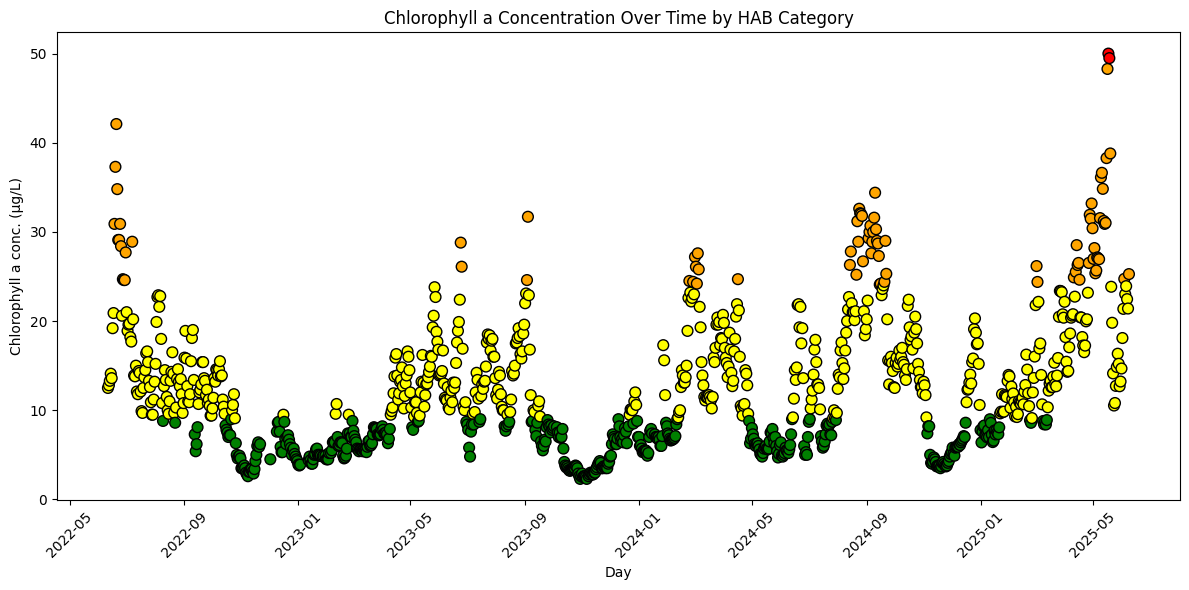

In [47]:
import matplotlib.pyplot as plt

# Map colors to the 'hab_category' column
colors = chl_data['hab_category'].map(color_map)

plt.figure(figsize=(12, 6))
plt.scatter(
    chl_data['datetime'],
    chl_data['32316_bn_Mean'],
    c=colors,  # Use mapped colors
    edgecolor='k',  # Optional: black outline for points
    s=60           # Optional: size of points
)

plt.title("Chlorophyll a Concentration Over Time by HAB Category")
plt.xlabel('Day')
plt.ylabel('Chlorophyll a conc. (μg/L)')
plt.xticks(rotation=45)

# Create a custom legend
import matplotlib.patches as mpatches
#legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
#plt.legend(handles=legend_handles, title='HAB Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Explore chl a categorical values

Feauture Engineering and data cleaning
- create categorical HABs variable
- create month and week variabales

## HAB category  <a name="plot_pie"></a>

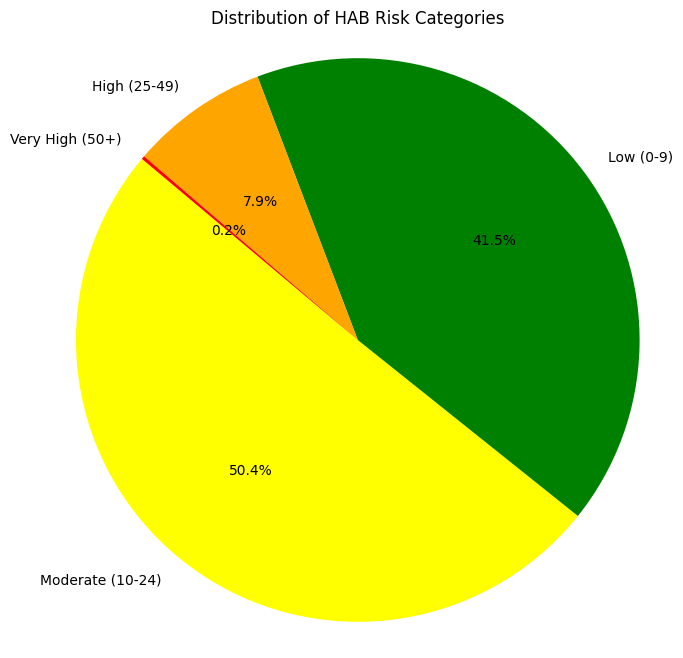

In [64]:
# Generate pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, 
        labels=category_counts.index,
        autopct='%1.1f%%', 
        startangle=140, 
        colors=[color_map.get(cat, 'gray') for cat in category_counts.index])

plt.title('Distribution of HAB Risk Categories')
plt.axis('equal')  # Ensures pie is circular
plt.show()

## Year and HAB category  <a name="plot_year"></a>

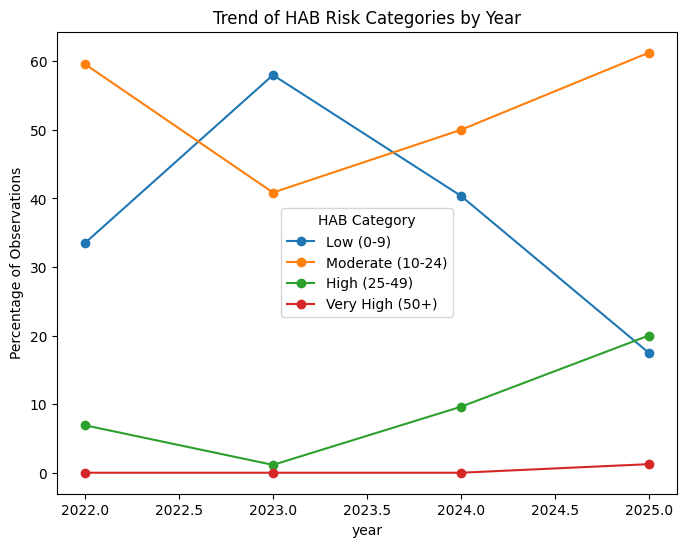

In [69]:
chl_data["year"] = chl_data["datetime"].dt.year

# Count observations by year and category
yearly_counts = chl_data.groupby(["year", "hab_category"], observed=False).size().unstack(fill_value=0)

# Convert counts to percentages per year
yearly_percent = yearly_counts.div(yearly_counts.sum(axis=1), axis=0) * 100

# Plot percentages with markers
yearly_percent.plot(marker='o', figsize=(8, 6))
plt.ylabel("Percentage of Observations")
plt.title("Trend of HAB Risk Categories by Year")
plt.legend(title="HAB Category")
plt.show()


Since 2023, the high and very high suspected habs have increased. In 2025, the first record of a very high probably record was recorded. From 2022-2024, all clorophyll values were less than 50 ug/L.

## Month and HAB category  <a name="plot_month"></a>

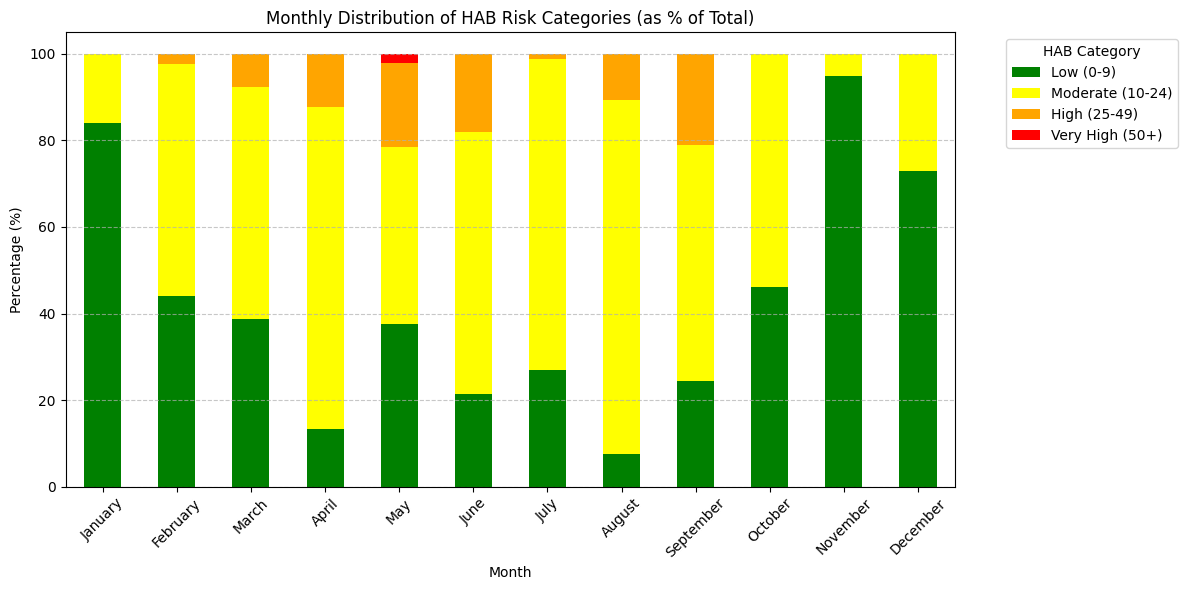

In [50]:
# Group by calendar month (1–12) and HAB category
monthly_counts = chl_data.groupby([chl_data['datetime'].dt.month, 'hab_category'], observed=False).size().unstack().fillna(0)

# Normalize each row to percent
monthly_percent = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100

# Rename rows from numbers to month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_percent.index = month_names

# Plot
monthly_percent.plot(kind='bar', stacked=True,
                     color=[color_map.get(col, 'gray') for col in monthly_percent.columns],
                     figsize=(12, 6))

plt.title('Monthly Distribution of HAB Risk Categories (as % of Total)')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='HAB Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Similar to the previous plot, we can see that 

## Calendar month and HAB category  <a name="plot_monthyear"></a>

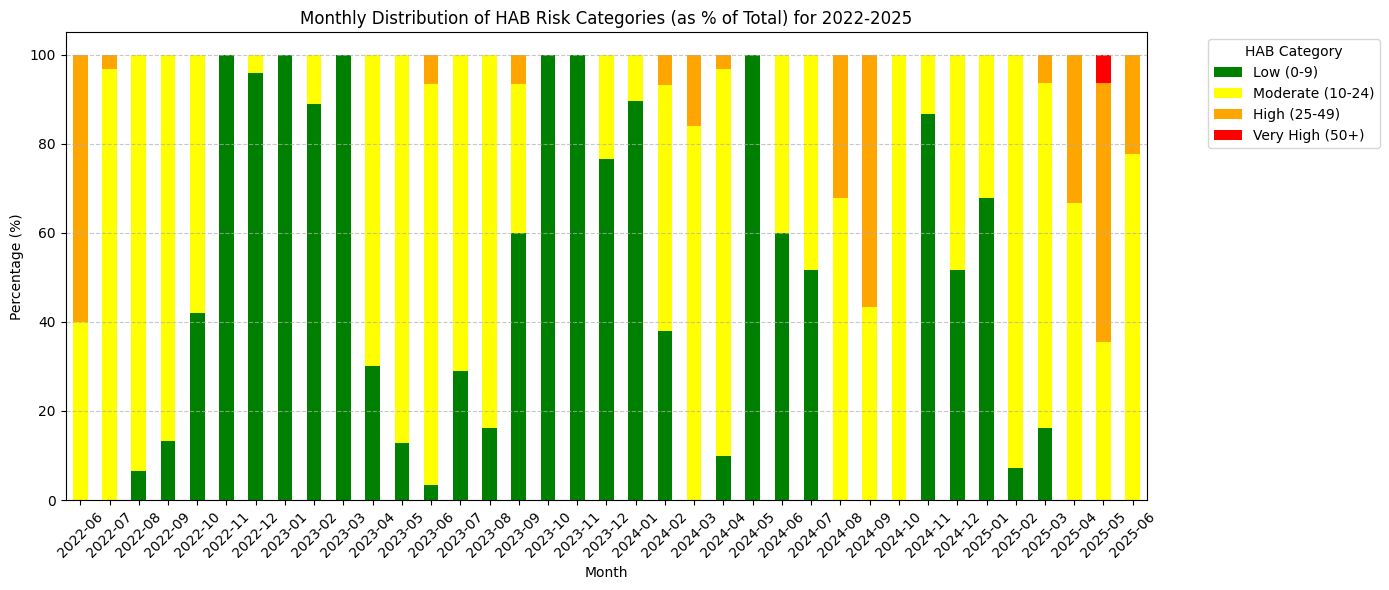

In [52]:
# which months 

# Extract month and year as a new column
# remove time zone from datetime to avoid warning 
chl_data['month'] = chl_data['datetime'].dt.tz_localize(None).dt.to_period('M')

# Count how many of each HAB category appear per month
monthly_counts = chl_data.groupby(['month', 'hab_category'], observed=False).size().unstack().fillna(0)

# Normalize to percentages
monthly_percents = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100

# Sort months chronologically
monthly_percents = monthly_percents.sort_index()

# Plot
monthly_percents.plot(kind='bar', stacked=True, color=[color_map.get(col, 'gray') for col in monthly_percents.columns], figsize=(14, 6))

plt.title('Monthly Distribution of HAB Risk Categories (as % of Total) for 2022-2025')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='HAB Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see 

## Line Chart By Calendar Week and HAB category  <a name="plot_weekyear"></a>

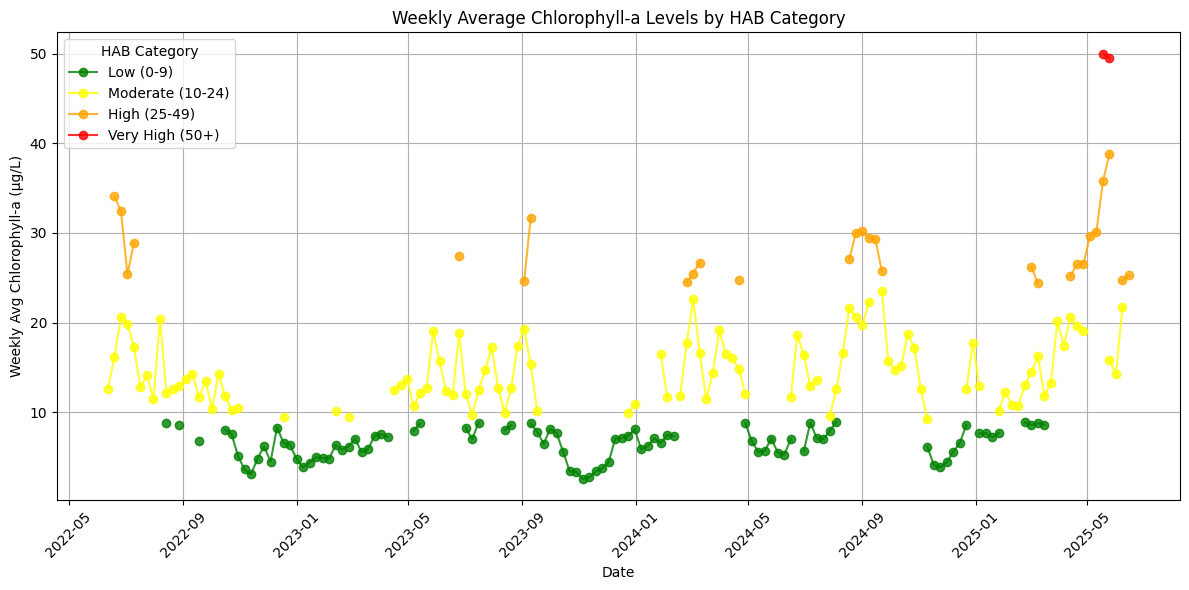

In [53]:
# Make sure datetime is a datetime object
chl_data['datetime'] = pd.to_datetime(chl_data['datetime'])

# Resample weekly and calculate average chlorophyll-a per category
weekly_df = (
    chl_data
    .set_index('datetime')
    .groupby('hab_category', observed=False)['32316_bn_Mean']
    .resample('W')
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))

for category, color in color_map.items():
    subset = weekly_df[weekly_df['hab_category'] == category]
    plt.plot(subset['datetime'], subset['32316_bn_Mean'], 
             label=category, color=color, marker='o', alpha=0.8)

plt.xlabel('Date')
plt.ylabel('Weekly Avg Chlorophyll-a (µg/L)')
plt.title('Weekly Average Chlorophyll-a Levels by HAB Category')
plt.xticks(rotation=45)
plt.legend(title='HAB Category')
plt.grid(True)
plt.tight_layout()
plt.show()

# explain each plot 




In [ ]:
# According to this state wide HABS metrics compilations, 
# high values are labeled as ___, explore distribution of high values

# look at instances of high chl a concentrations.

# histograms 

# month category


# Compare relationship between chlorophyll a concentration and water temperature 

In [ ]:
Add sentences to transition between each part of the reports. 
 #   add section to compare to diff from daily value to identify relationship

In [ ]:
# explain plot
# We know chlorphyll flunctuates quickly so the 2-week moving average works.

## Time series analysis  <a name="timeseries"></a>

<Figure size 1200x600 with 0 Axes>

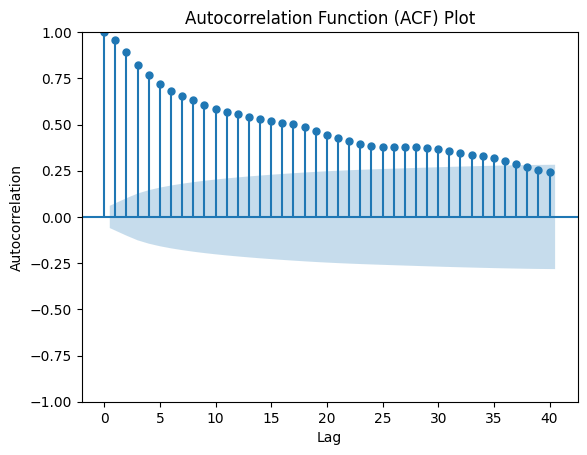

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

plt.figure(figsize=(12, 6))
plot_acf(chl_data['32316_bn_Mean'], lags=40) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

In [ ]:
# Non stationary
# Exhibits strong autocorrelation, will proceed with time series analysis 



## Adfuller  <a name="test_adf"></a>

In [56]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(chl_data['32316_bn_Mean'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.2252418452290312
p-value: 0.018569292309262977
Critical Values: {'1%': np.float64(-3.436647308529461), '5%': np.float64(-2.864320407484321), '10%': np.float64(-2.568250401889486)}


In [598]:
result

(np.float64(-3.7515462155857655),
 np.float64(0.0034438390264480115),
 20,
 1041,
 {'1%': np.float64(-3.436647308529461),
  '5%': np.float64(-2.864320407484321),
  '10%': np.float64(-2.568250401889486)},
 np.float64(4253.054147948273))

In [ ]:
# Your time series is stationary at the 1%, 5%, and 10% significance levels.

## KPSS <a name="test_kpss"></a>

In [58]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, _, crit = kpss(chl_data['32316_bn_Mean'].dropna(), regression='c')
print(f"KPSS Statistic: {kpss_stat}, p-value: {p_value}")

# Stationary is the null
# reject null hypothesis

KPSS Statistic: 0.6783766086813167, p-value: 0.015511217392607574


In [ ]:
# Augmented was reject
# KPSS was rejected
# thus we conclused our data is trend stationary
#ADF detects stationarity after removing autocorrelation (like a differencing).

#KPSS detects non-stationarity because there's a deterministic trend present.

#Your data has a consistent upward or seasonal trend, but otherwise behaves stably around that trend.

## 3-month forecast  <a name="plot_monthlyforecast"></a>

C:\Users\jacki\AppData\Local\Temp\ipykernel_36052\3031875845.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = chl_data['32316_bn_Mean'].resample('M').mean()


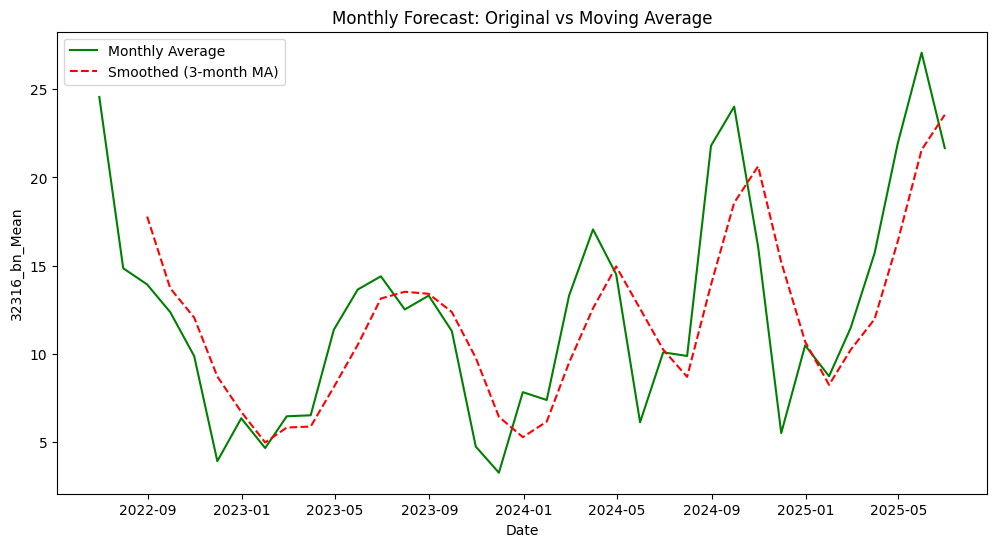

In [60]:
# Monthly Forecast Plot
chl_data = chl_data.set_index('datetime')

monthly_data = chl_data['32316_bn_Mean'].resample('M').mean()
monthly_smoothed = monthly_data.rolling(window=3).mean()  # 3-month moving average

plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Monthly Average', color='green')
plt.plot(monthly_smoothed, label='Smoothed (3-month MA)', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('32316_bn_Mean')
plt.title('Monthly Forecast: Original vs Moving Average')
plt.legend()
plt.show()

## 4 week forecast  <a name="plot_weeklyforecast"></a>

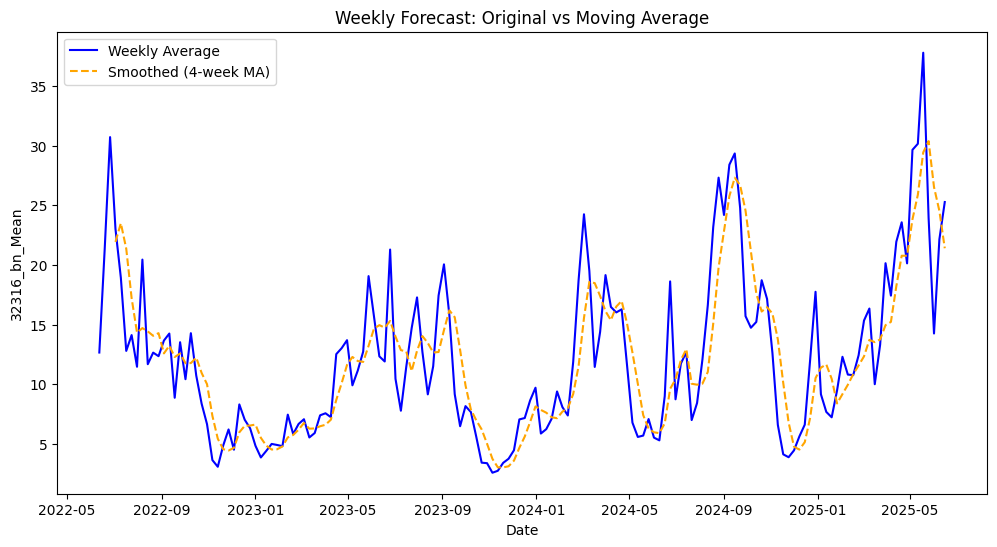

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure 'datetime' is the index
ma_chl_data = chl_data.set_index('datetime')

# Weekly Forecast Plot
weekly_data = ma_chl_data['32316_bn_Mean'].resample('W').mean()
weekly_smoothed = weekly_data.rolling(window=4).mean()  # 4-week moving average

plt.figure(figsize=(12, 6))
plt.plot(weekly_data, label='Weekly Average', color='blue')
plt.plot(weekly_smoothed, label='Smoothed (4-week MA)', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('32316_bn_Mean')
plt.title('Weekly Forecast: Original vs Moving Average')
plt.legend()
plt.show()


# Conclusion  <a name="conclusion"></a>

The data retrieval package is a useful tool for analyzing. 

In [ ]:
# Next Steps, join with data set from JEnny oorcid DOI (algal compilation thersholds, are they the same)